# Изучение влияния COVID-19 на объем авиаперевозок

Одна из наиболее пострадавших сфер из-за пандемии COVID-19 - авиаперевозки. Из-за закрытия границ и аэропортов авиакомпании потеряли миллионов пассажиров. Попробуем разобраться в деталях, как повлияла пандемия на воздушный трафик.

Датасет содержит информацию о количестве людей, прилетающих и улетающих из аэропортов США, Канады, Австралии и Чили в период с 16 марта по 2 декабря 2020 года. Количество выражается в долях от среднего количества поездок в тот же день недели в базовом периоде - с 1 февраля по 15 марта 2020 года (когда пандемия еще не успела затронуть сферу авиаперевозок в рассматриваемых странах).

## Описание колонок
* AggregationMethod - метод агрегации, используемый для рассчета данных.
* Date - дата в формате гггг-мм-дд.
* Version - в какой версии датасета была добавлена информация о наблюдении.
* AirportName - название аэропорта.
* PercentOfBaseline - доля поездок в эту дату по сравнению со средним количеством поездок в тот же день недели в базовом периоде, т.е. с 1 февраля 2020 года по 15 марта 2020 года.
* Centroid - географические координаты центра полигона аэропорта.
* City - город, в котором расположен аэропорт.
* State - штат, в котором расположен аэропорт.
* ISO_3166_2 - код ISO-3166-2, отображающий страну и штат.
* Country - страна, в которой расположен аэропорт.
* Geography - географические координаты всего полигона аэропорта.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Загрузим данные и посмотрим на них.

In [ ]:
airport_data = pd.read_csv('covid_impact_on_airport_traffic.csv')

In [ ]:
airport_data.head()

,AggregationMethod,Date,Version,AirportName,PercentOfBaseline,Centroid,City,State,ISO_3166_2,Country,Geography
0,Daily,2020-04-03,1.0,Kingsford Smith,64,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
1,Daily,2020-04-13,1.0,Kingsford Smith,29,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
2,Daily,2020-07-10,1.0,Kingsford Smith,54,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
3,Daily,2020-09-02,1.0,Kingsford Smith,18,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
4,Daily,2020-10-31,1.0,Kingsford Smith,22,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."


In [ ]:
airport_data.shape

(7247, 11)

Прежде чем начать работу, проверим наличие пропусков, дубликатов и корректность типов данных столбцов.

In [ ]:
airport_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7247 entries, 0 to 7246
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AggregationMethod  7247 non-null   object 
 1   Date               7247 non-null   object 
 2   Version            7247 non-null   float64
 3   AirportName        7247 non-null   object 
 4   PercentOfBaseline  7247 non-null   int64  
 5   Centroid           7247 non-null   object 
 6   City               7247 non-null   object 
 7   State              7247 non-null   object 
 8   ISO_3166_2         7247 non-null   object 
 9   Country            7247 non-null   object 
 10  Geography          7247 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 622.9+ KB


In [ ]:
airport_data.duplicated().sum()

0

Дата записана в виде строки. Это может быть неудобно при дальнешей работе с данными, поэтому приведем ее к нужному типу. Также заранее создадим колонку с месяцами и днями недели.

In [ ]:
airport_data['Date'] = pd.to_datetime(airport_data['Date'], format="%Y-%m-%d")

In [ ]:
airport_data['Month'] = airport_data['Date'].dt.month
airport_data['Weekday'] = airport_data['Date'].dt.weekday

In [ ]:
airport_data.head(3)

,AggregationMethod,Date,Version,AirportName,PercentOfBaseline,Centroid,City,State,ISO_3166_2,Country,Geography,Month,Weekday
0,Daily,2020-04-03,1.0,Kingsford Smith,64,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",4,4
1,Daily,2020-04-13,1.0,Kingsford Smith,29,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",4,0
2,Daily,2020-07-10,1.0,Kingsford Smith,54,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",7,4


Рассмотрим колонки AggregationMethod и Version.

In [ ]:
airport_data['AggregationMethod'].nunique()

1

In [ ]:
airport_data['Version'].nunique()

1

Эти столбцы принимают только одно значение во всем датасете. Для анализа данных они не пригодятся. Избавимся от них.

In [ ]:
airport_data.drop(['Version', 'AggregationMethod'], axis=1, inplace=True)

In [ ]:
airport_data.head(3)

,Date,AirportName,PercentOfBaseline,Centroid,City,State,ISO_3166_2,Country,Geography,Month,Weekday
0,2020-04-03,Kingsford Smith,64,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",4,4
1,2020-04-13,Kingsford Smith,29,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",4,0
2,2020-07-10,Kingsford Smith,54,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",7,4


Убедимся, что даты, представленные в датасете, соответствуют описанию.

In [ ]:
airport_data.Date.min(), airport_data.Date.max()

(Timestamp('2020-03-16 00:00:00'), Timestamp('2020-12-02 00:00:00'))

Все в порядке.

Проверим страны, присутствующие в датасете.

In [ ]:
countries = airport_data['Country'].value_counts()
countries

United States of America (the)    4441
Canada                            2311
Australia                          257
Chile                              238
Name: Country, dtype: int64

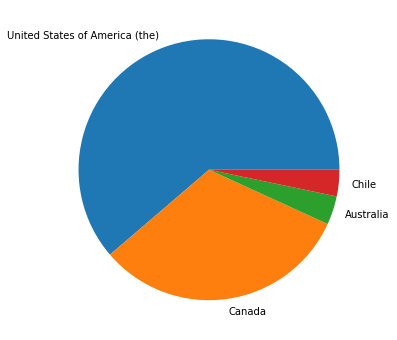

In [ ]:
values = countries.values
labels = countries.keys()
plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels)
plt.show()

Посмотрим как менялся траффик авиаперевозок в течение года в каждой стране.

In [ ]:
countries_traffic = airport_data.pivot_table(index='Month',
                                             columns='Country', 
                                             values='PercentOfBaseline',
                                             aggfunc='mean')

countries_traffic

Country,Australia,Canada,Chile,United States of America (the)
Month,,,,
3,83.125000,77.070423,38.400000,70.180147
4,53.241379,63.391473,19.571429,54.821569
5,49.129032,71.885185,21.444444,55.385199
6,52.517241,80.312030,26.846154,62.464706
7,46.258065,78.300725,31.107143,65.286528
8,17.793103,76.763158,33.269231,67.717899
9,16.400000,79.868421,37.206897,69.096078
10,19.387097,83.064516,47.806452,70.614801
11,23.827586,84.248148,52.538462,66.590196


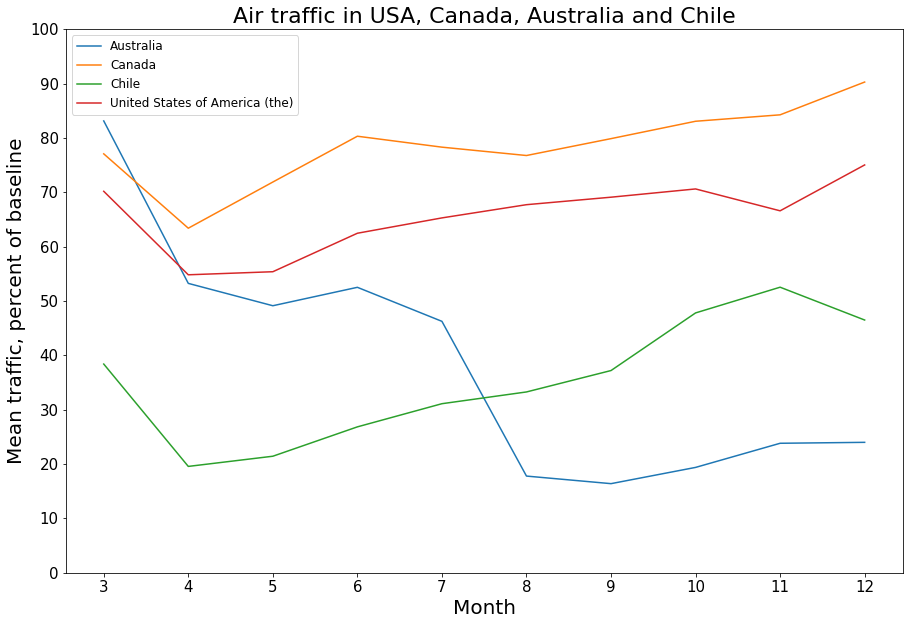

In [ ]:
countries_traffic.plot(figsize=(15, 10))
plt.title("Air traffic in USA, Canada, Australia and Chile", fontsize=22)
plt.xlabel("Month", fontsize=20)
plt.ylabel("Mean traffic, percent of baseline", fontsize=20)
plt.xticks(np.arange(3, 13, 1), fontsize=15)
plt.yticks(np.arange(0, 101, 10), fontsize=15)
plt.ylim=(0, 100)
plt.legend(fontsize=12)
plt.show()

Интересно проверить, есть ли статистически значимые различия между авиатрафиком США и Канады (см. гипотезу 1).

Вообще бросается в глаза, что авиаперевозки в Чили и Австралии упали сильнее, чем в США и Канаде. Чтобы объяснить это, посмотрим на количество аэропортов в этих странах.

In [ ]:
airports_per_country = airport_data.groupby('Country', as_index=False) \
    .agg({'AirportName': 'nunique'}) \
    .rename({'AirportName': 'AirportsTotal'}, axis=1) \
    .sort_values(by='AirportsTotal')

airports_per_country

,Country,AirportsTotal
0,Australia,1
2,Chile,1
1,Canada,9
3,United States of America (the),17


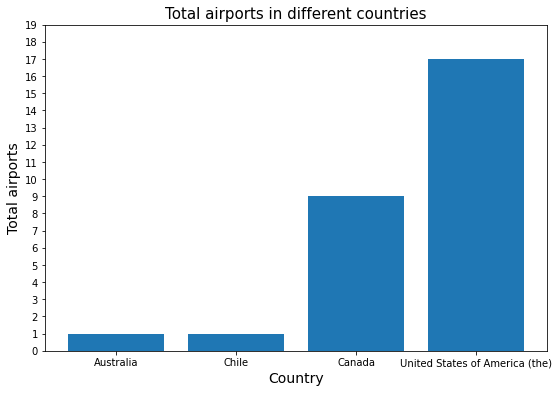

In [ ]:
plt.figure(figsize=(9, 6))
plt.bar(airports_per_country['Country'], airports_per_country['AirportsTotal'])
plt.title('Total airports in different countries', fontsize=15)
plt.xlabel('Country', fontsize=14)
plt.ylabel("Total airports", fontsize=14)
plt.yticks(np.arange(0, 20))
plt.show()

В датасете представлена информация только об 1 аэропорте в Австралии и об 1 аэропорте в Чили, хотя у Канады и США есть данные о 9 и 17 аэропортах соответственно.

Посмотрим, какие аэропорты из Чили и Австралии у нас есть.

In [ ]:
airport_data.query("Country == 'Australia'")['AirportName'].unique()

array(['Kingsford Smith'], dtype=object)

In [ ]:
airport_data.query("Country == 'Chile'")['AirportName'].unique()

array(['Santiago International Airport'], dtype=object)

Обратившись в интернет, я выяснил, что аэропорты Сантьяго и Сиднея (Кингсфорд Смит) - крупнейшие аэропорты Чили и Австралии, положение которых явно будет отображать положение остальных аэропортов этих стран. Поэтому нам нет смысла рассматривать абсолютно все аэровокзалы - общая картина не поменяется.

Аналогичная ситуация с Америкой: в датасете представлены только крупные аэропорты.

Рассмотрим как менялся траффик по дням в аэропортах. Для исследования возьмем крупнейшие аэропорты представленных стран - аэропорт Джона Кеннеди в Нью Йорке, аэропорт Торонто и аэропорты Сантьяго и Сиднея (тут даже выбирать не пришлось с:)

In [ ]:
hugest_airports = ['John F. Kennedy International', 'Toronto Pearson', 'Santiago International Airport', 'Kingsford Smith']

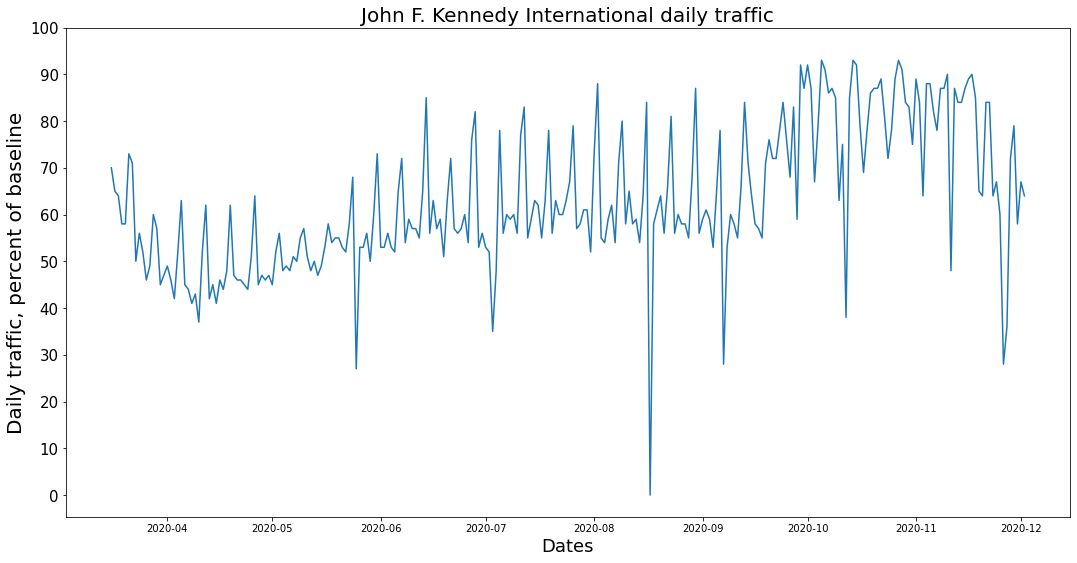

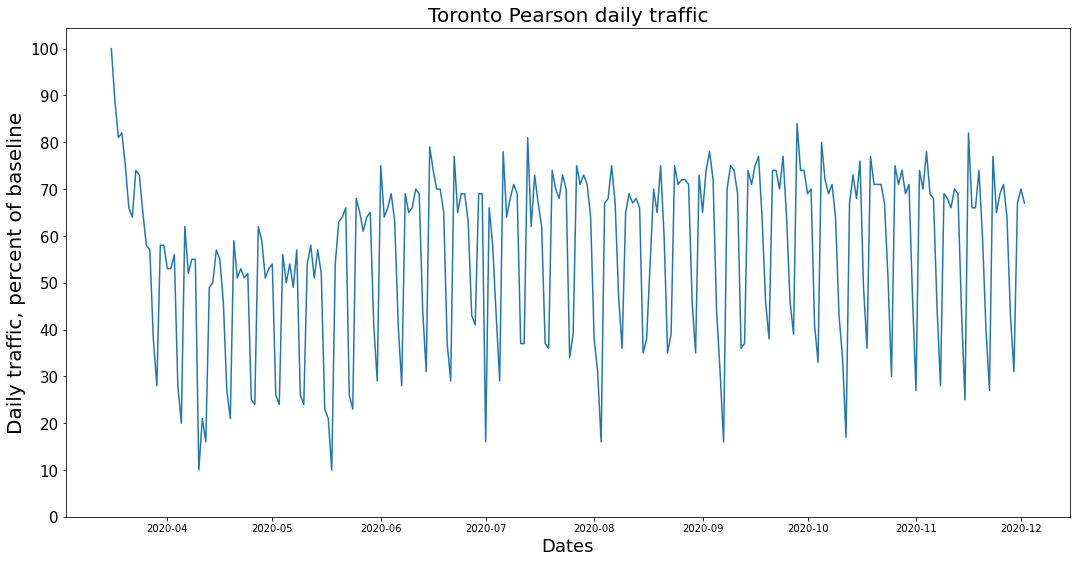

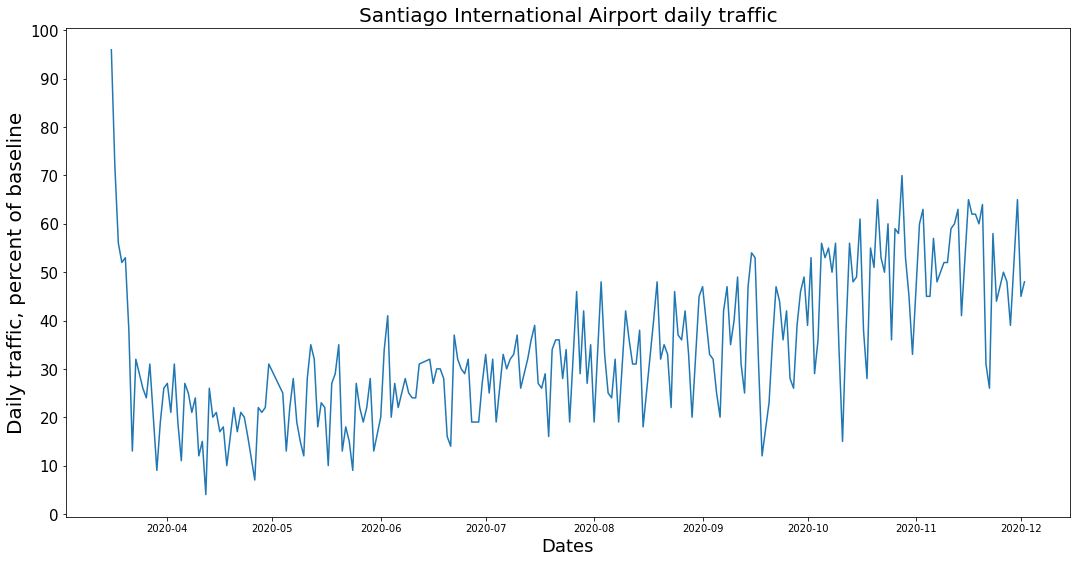

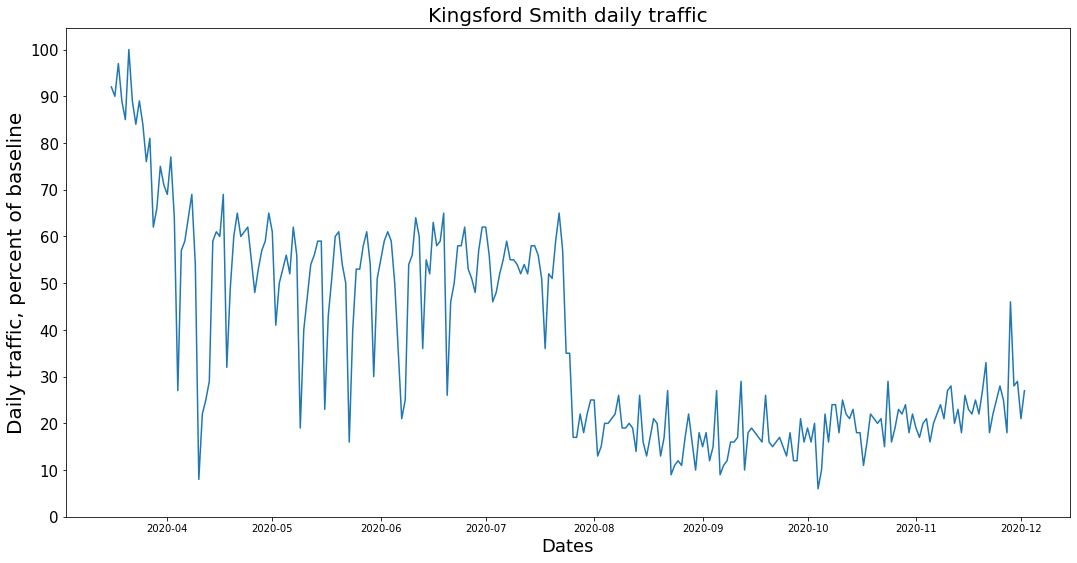

In [ ]:
for airport in hugest_airports:
    airport_dates = airport_data.query("AirportName == @airport")[['Date', 'PercentOfBaseline']] \
        .sort_values(by='Date')
    
    plt.figure(figsize=(18, 9))
    plt.plot(airport_dates['Date'], airport_dates['PercentOfBaseline'])
    plt.title(airport + " daily traffic", fontsize=20)
    plt.xlabel("Dates", fontsize=18)
    plt.ylabel("Daily traffic, percent of baseline", fontsize=20)
    plt.xticks()
    plt.yticks(np.arange(0, 101, 10), fontsize=15)
    plt.ylim=(0, 100)
    plt.show()

Графики очень скачкообразные. Возможно, на выходных количество желающих полетать падало. Посмотрим, зависит ли спад траффика от дня недели.

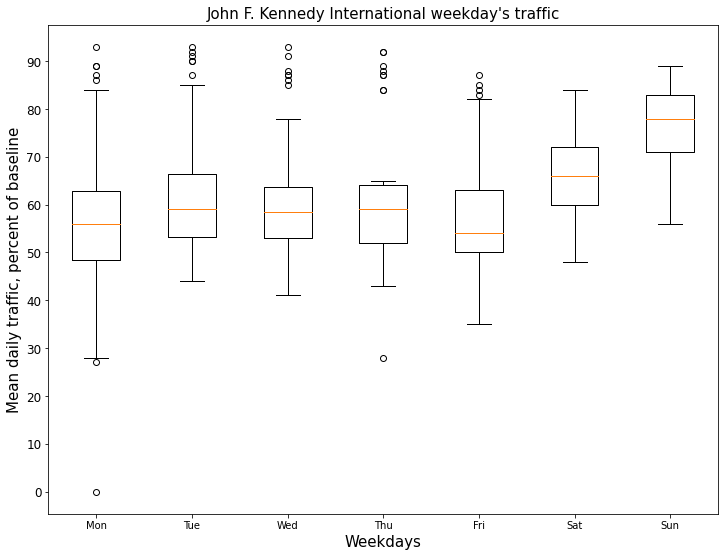

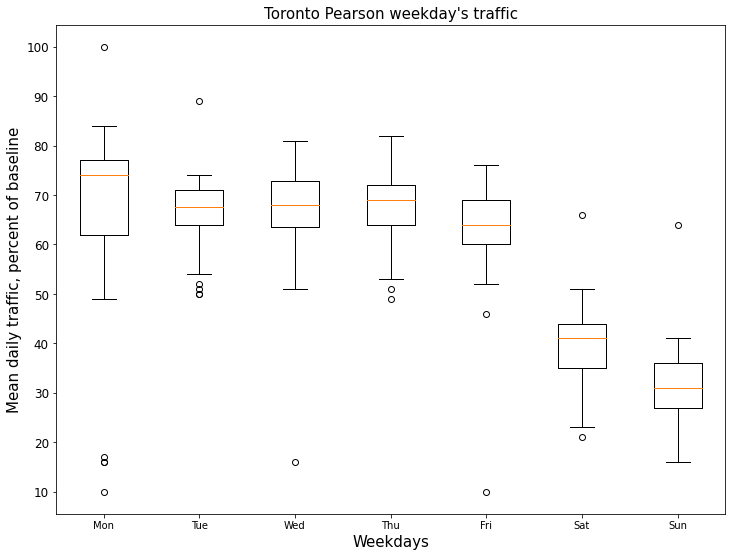

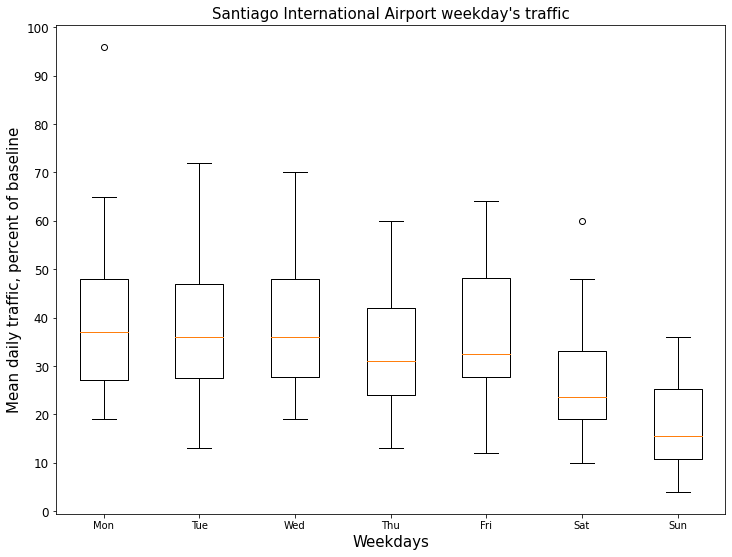

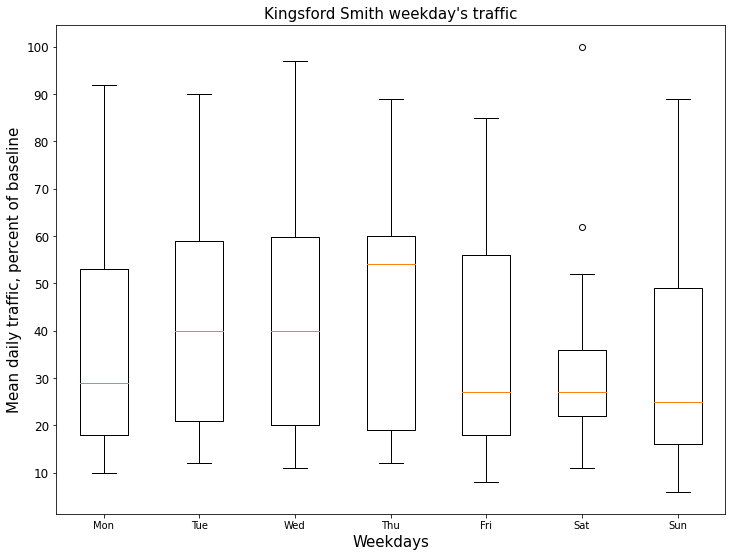

In [ ]:
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for airport in hugest_airports:
    airport_weekdays = airport_data.query("AirportName == @airport")[['Weekday', 'PercentOfBaseline']]

    weekday_dfs = []
    for weekday in range(7):
        weekday_dfs.append(airport_weekdays.query("Weekday == @weekday")['PercentOfBaseline'])

    plt.figure(figsize=(12, 9))
    plt.title(airport + " weekday's traffic", fontsize=15)
    plt.xlabel("Weekdays", fontsize=15)
    plt.ylabel("Mean daily traffic, percent of baseline", fontsize=15)
    plt.yticks(np.arange(0, 101, 10), fontsize=12)
    plt.ylim=(0, 100)
    plt.boxplot(weekday_dfs, labels=weekday_labels)
    plt.show()

Действительно, в выходные дни почти во всех из представленных аэропортов траффик снижался. Особенно заметно это снижение в аэропортах Торонто и Сантьяго в субботу и воскресенье. Также выделяются субботние показатели австралийского аэропорта. Хотя в аэропорте Нью-Йорка (Джона Кеннеди) траффик на выходных, наоборот, увеличивался.

Посмотрим на то, как меняется воздушный трафик в зависимости от дня недели во всех странах.

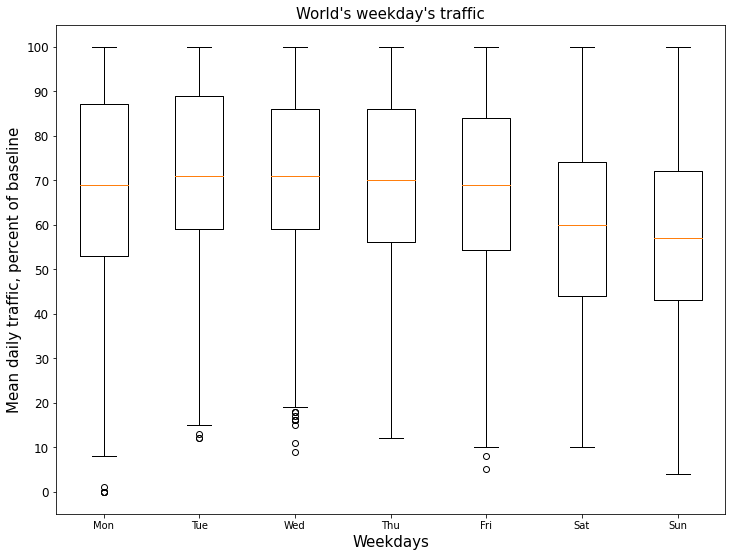

In [ ]:
weekday_dfs_world = []
for weekday in range(7):
    weekday_dfs_world.append(airport_data.query("Weekday == @weekday")['PercentOfBaseline'])


plt.figure(figsize=(12, 9))
plt.title("World's weekday's traffic", fontsize=15)
plt.xlabel("Weekdays", fontsize=15)
plt.ylabel("Mean daily traffic, percent of baseline", fontsize=15)
plt.yticks(np.arange(0, 101, 10), fontsize=12)
plt.ylim=(0, 100)
plt.boxplot(weekday_dfs_world, labels=weekday_labels)
plt.show()

Снова замечаем снижение медианы на выходных. Но всё же интересно проверить, есть ли **статистически** значимые различия между будним и выходным трафиком (см. гипотезу 2).

Ну и наконец рассчитаем, на сколько в среднем снизился уровень авиаперевозок в каждой стране.

In [ ]:
airport_data.groupby('Country') \
    .agg({'PercentOfBaseline': 'mean'}) \
    .rename({'PercentOfBaseline': 'MeanPercentOfBaseline'}, axis=1)

,MeanPercentOfBaseline
Country,
Australia,37.750973
Canada,77.409347
Chile,34.273109
United States of America (the),64.460932


Осталось посмотреть, насколько восстановился объем авиаперевозок в этих странах. Для этого рассчитаем средний трафик за последний месяц - ноябрь (о декабре данных слишком мало, чтобы делать на их основе какие-либо выводы).

In [ ]:
airport_data.query('Month == 11') \
    .groupby('Country') \
    .agg({'PercentOfBaseline': 'mean'}) \
    .rename({'PercentOfBaseline': 'NovemberPercentOfBaseline'}, axis=1)

,NovemberPercentOfBaseline
Country,
Australia,23.827586
Canada,84.248148
Chile,52.538462
United States of America (the),66.590196


По полученным результатам можно судить о том, на сколько процентов восстановились авиаперевозки в каждой стране к концу 2020 года.

## Проверка гипотез

Во время анализа данных у меня возникли следующие предположения:  
### 1. Среднее значение авиатрафика в Канаде было больше, чем в США.

$H_0$: Среднее значение авиатрафика в Канаде равно среднему в США.

$H_1$: Среднее значение авиатрафика в Канаде не равно среднему в США.

Для проверки воспользуемся t-тестом для сравнения среднего двух генеральных совокупностей.

Установим пороговый уровень, равный 0.05

In [ ]:
usa_traffic = airport_data.query("Country == 'United States of America (the)'")['PercentOfBaseline']
canada_traffic = airport_data.query("Country == 'Canada'")['PercentOfBaseline']

In [ ]:
test1 = st.ttest_ind(
    usa_traffic,
    canada_traffic
)

In [ ]:
test1.pvalue < 0.05

True

Отклоняем нулевую гипотезу. Значит средние значения трафика в Канаде отличаются от среднего трафика в США (причем, судя по графику, среднее по Канаде больше).

### 2. Среднее значение авиатрафика в выходные дни было меньше, чем в будние.

$H_0$: Среднее значение авиатрафика в выходные дни равно среднему в в будние.

$H_1$: Среднее значение авиатрафика в выходные дни не равно среднему в в будние.

Для проверки снова воспользуемся t-тестом для сравнения среднего двух генеральных совокупностей.

И снова установим пороговый уровень, равный 0.05

In [ ]:
weekday_traffic_workdays = airport_data.query("0 <= Weekday <= 4")['PercentOfBaseline']
weekday_traffic_weekends = airport_data.query("5 <= Weekday <= 6")['PercentOfBaseline']

In [ ]:
test2 = st.ttest_ind(
    weekday_traffic_workdays,
    weekday_traffic_weekends
)

In [ ]:
test2.pvalue < 0.05

True

Отклоняем нулевую гипотезу. Средий трафик в рабочие дни действительно отличается от трафика на уикэндах.

# Выводы

Итак, мы рассмотрели трафик воздушного транспорта в четырех странах. Подведем итоги.

* Менее всего пострадали от пандемии авиаперевозки в Канаде. В среднем их объем снизился на 23%.
* Сильнее всего пострадали авиаперевозки в Чили и Австралии. Их объем снизился на 66% и 63% соответственно.
* Воздушный трафик США снизился в среднем на 36%.
* Существуют статистически значимые различия между объемом авиаперевозок в рабочие дни и в выходные. Но эта тенденция просматривается не во всех аэропортах - например, в Нью-Йоркском аэропорте Джона Кеннеди в выходные дни объем авиаперевозок наоборот повышался.
* Уровень восстановления авиаперевозок к декабрю 2020 года:  
    * Канада - 84%  
    * США - 66%  
    * Австралия - 23%  
    * Чили - 53%